In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
from pyballmapper import BallMapper
from pyballmapper.plotting import graph_GUI
from bokeh.plotting import figure, show

from matplotlib import colormaps as cm

In [3]:
# this cell allows for bokeh plots to be displayed inside jupyter notebooks
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

## Preprocessing

In [4]:
def check_victory(c, s):  # c array of configurations, s symbol
    c = c.reshape(3, 3)

    target = [s, s, s]  # target

    for row in c:
        if list(row) == target:
            return True
    for row in c.T:
        if list(row) == target:
            return True

    # check diagonals
    if list(c.diagonal()) == target:
        return True
    if list(np.fliplr(c).diagonal()) == target:
        return True

    # if here, return false
    return False

In [5]:
data = pd.read_csv(
    "../data/tic-tac-toe.data", header=None, names=[i for i in range(9)] + ["outcome"]
)

In [6]:
data

,0,1,2,3,4,5,6,7,8,outcome
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


In [7]:
my_outcome = []

for row in data[[i for i in range(9)]].values:
    if check_victory(row, "x"):
        my_outcome.append(1)
    elif check_victory(row, "o"):
        my_outcome.append(-1)
    else:
        my_outcome.append(0)

data["my_outcome"] = my_outcome

In [8]:
data

,0,1,2,3,4,5,6,7,8,outcome,my_outcome
0,x,x,x,x,o,o,x,o,o,positive,1
1,x,x,x,x,o,o,o,x,o,positive,1
2,x,x,x,x,o,o,o,o,x,positive,1
3,x,x,x,x,o,o,o,b,b,positive,1
4,x,x,x,x,o,o,b,o,b,positive,1
...,...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative,0
954,o,x,o,x,x,o,x,o,x,negative,0
955,o,x,o,x,o,x,x,o,x,negative,0
956,o,x,o,o,x,x,x,o,x,negative,0


In [9]:
data.my_outcome.value_counts()

my_outcome
 1    626
-1    316
 0     16
Name: count, dtype: int64

In [10]:
data_num = data.replace({"x": 1, "o": -1, "b": 0, "positive": 1, "negative": -1})

/var/folders/4s/_33kvc6507v69vbr_vy9xsjc0000gq/T/ipykernel_9123/3256920960.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_num = data.replace({"x": 1, "o": -1, "b": 0, "positive": 1, "negative": -1})


In [11]:
data_num

,0,1,2,3,4,5,6,7,8,outcome,my_outcome
0,1,1,1,1,-1,-1,1,-1,-1,1,1
1,1,1,1,1,-1,-1,-1,1,-1,1,1
2,1,1,1,1,-1,-1,-1,-1,1,1,1
3,1,1,1,1,-1,-1,-1,0,0,1,1
4,1,1,1,1,-1,-1,0,-1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
953,-1,1,1,1,-1,-1,-1,1,1,-1,0
954,-1,1,-1,1,1,-1,1,-1,1,-1,0
955,-1,1,-1,1,-1,1,1,-1,1,-1,0
956,-1,1,-1,-1,1,1,1,-1,1,-1,0


In [12]:
number_of_moves = []

for game in data_num.iloc[:, :9].values:
    number_of_moves.append(np.count_nonzero(game))

data_num["number_of_moves"] = number_of_moves

In [13]:
data_num["number_of_moves"].min()

5

In [14]:
data_num[data_num.outcome != data_num.my_outcome].shape

(16, 12)

## Standard BM

In [22]:
X = data_num.iloc[:, :9].to_numpy(dtype=float)
y = data_num[["my_outcome", "number_of_moves"]]

print(X.shape, y.shape)

(958, 9) (958, 2)


In [23]:
def my_distance(x, y):
    return (x != y).sum()

In [24]:
my_distance(X[1], X[2])

2

In [25]:
from scipy.spatial.distance import cityblock

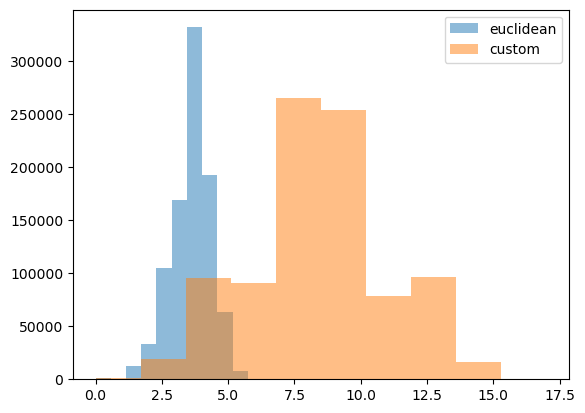

In [26]:
from sklearn.metrics import pairwise_distances

plt.hist(
    pairwise_distances(X, X, metric="euclidean").flatten(), label="euclidean", alpha=0.5
)
plt.hist(
    pairwise_distances(X, X, metric="manhattan").flatten(), label="custom", alpha=0.5
)
plt.legend()
plt.show()

In [27]:
EPS_EUC = 1.7

connect4_euc_bm = BallMapper(
    X=X,  # the pointcloud, as a numpy array
    eps=EPS_EUC,
)

connect4_euc_bm.add_coloring(coloring_df=y[["my_outcome"]])

my_red_palette = cm.get_cmap("Reds")
my_euc_gui = graph_GUI(
    connect4_euc_bm.Graph,
    my_red_palette,
)
my_euc_gui.color_by_variable("my_outcome")

show(my_euc_gui.plot)

color by variable my_outcome 
MIN_VALUE: -1.000, MAX_VALUE: 1.000


## Orbit 8

In [42]:
X = data_num.iloc[:, :9].to_numpy(dtype=float)
y = data_num[["my_outcome"]]

print(X.shape, y.shape)

(958, 9) (958, 1)


In [30]:
def are_equivalent(conf1, conf2):

    to_check = [
        conf2.tolist(),  # ID
        np.rot90(conf2.reshape(3, 3), k=1).reshape(-1).tolist(),  # R 90
        np.rot90(conf2.reshape(3, 3), k=2).reshape(-1).tolist(),  # R 180
        np.rot90(conf2.reshape(3, 3), k=3).reshape(-1).tolist(),  # R 270
        conf2.reshape(3, 3)[:, ::-1].reshape(-1).tolist(),  # L vertical
        conf2.reshape(3, 3)[::-1, :].reshape(-1).tolist(),  # L horizontal
        conf2.reshape(3, 3).T.reshape(-1).tolist(),  # L diagonal 1
        conf2.reshape(3, 3)[::-1, ::-1]
        .T.reshape(-1)
        .tolist(),  # L diagonal 2 (rotate and transpose)
    ]

    if conf1.tolist() in to_check:
        return True
    else:
        return False

In [31]:
orbits = []

for conf1 in tqdm(X):
    this_orbit = []
    for i, conf2 in enumerate(X):
        if are_equivalent(conf1, conf2):
            this_orbit.append(i)
    orbits.append(this_orbit)

y["orbit_id"] = [min(o) for o in orbits]

  0%|          | 0/958 [00:00<?, ?it/s]

/var/folders/4s/_33kvc6507v69vbr_vy9xsjc0000gq/T/ipykernel_9123/401924797.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["orbit_id"] = [min(o) for o in orbits]


In [43]:
orbits

[[0, 23, 160, 388],
 [1, 22, 79, 158, 297, 328, 334, 376],
 [2, 21, 80, 115, 132, 176, 306, 378],
 [3, 26, 82, 199, 316, 478, 557, 616],
 [4, 25, 101, 197, 491, 544, 582, 584],
 [5, 24, 103, 161, 402, 480, 495, 614],
 [6, 55, 81, 278, 307, 415, 574, 598],
 [7, 54, 83, 251, 315, 453, 465, 470],
 [8, 53, 102, 249, 420, 440, 490, 569],
 [9, 36, 84, 202, 308, 416, 547, 572],
 [10, 35, 85, 167, 317, 405, 466, 468],
 [11, 34, 104, 165, 390, 418, 492, 570],
 [12, 14, 113, 122, 150, 173, 382, 385],
 [13, 144, 331, 367],
 [12, 14, 113, 122, 150, 173, 382, 385],
 [15, 17, 154, 194, 395, 479, 551, 615],
 [16, 190, 537, 583],
 [15, 17, 154, 194, 395, 479, 551, 615],
 [18, 52, 151, 275, 384, 417, 573, 591],
 [19, 51, 155, 245, 394, 446, 467, 469],
 [20, 50, 191, 242, 419, 433, 536, 571],
 [2, 21, 80, 115, 132, 176, 306, 378],
 [1, 22, 79, 158, 297, 328, 334, 376],
 [0, 23, 160, 388],
 [5, 24, 103, 161, 402, 480, 495, 614],
 [4, 25, 101, 197, 491, 544, 582, 584],
 [3, 26, 82, 199, 316, 478, 557, 616

In [44]:
y

,my_outcome
0,1
1,1
2,1
3,1
4,1
...,...
953,0
954,0
955,0
956,0


In [46]:
y["norm"] = np.linalg.norm(X, axis=1)

/var/folders/4s/_33kvc6507v69vbr_vy9xsjc0000gq/T/ipykernel_9123/479879783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["norm"] = np.linalg.norm(X, axis=1)


In [47]:
y.tail(20)

,my_outcome,norm
938,-1,2.44949
939,-1,2.44949
940,-1,2.44949
941,-1,2.44949
942,0,3.00000
943,0,3.00000
944,0,3.00000
945,0,3.00000
946,0,3.00000
947,0,3.00000


In [48]:
X.dtype

dtype('float64')

In [49]:
EPS_EQ = np.sqrt(3) - 0.1

connect4_euc_bm_T = BallMapper(
    X=X,  # the pointcloud, as a numpy array
    eps=EPS_EQ,
    orbits=orbits,
)  # the radius of the balls

connect4_euc_bm_T.add_coloring(y)

my_palette = cm.get_cmap("Reds_r")

my_euc_gui = graph_GUI(
    connect4_euc_bm_T.Graph,
    my_palette,
    ["my_outcome", "orbit_id", "norm", "number_of_moves"],
)
# title='connect4 Euclidean BM with all symms eps={}'.format(EPS_EQ))
my_euc_gui.color_by_variable("my_outcome")

show(my_euc_gui.plot)

color by variable my_outcome 
MIN_VALUE: -1.000, MAX_VALUE: 1.000
